## Summary
1) Try removing high-correlated features. 

2) Try tweaking random forest parameters.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

sns.set_context('poster')
%matplotlib inline

In [2]:
loc = '/Users/elena/Documents/Kaggle/Allstate/data/'
train = pd.read_csv(loc+'train.csv')
train.columns

test = pd.read_csv(loc+'test.csv')

In [3]:
# List of categorical columns
keepcats = [col for col in train.columns if 'cat' in col]
# List of continuous columns
keepcont = [col for col in train.columns if 'cont' in col]

print 'Categorical: ',len(keepcats)
print 'Continuous: ',len(keepcont)

Categorical:  116
Continuous:  14


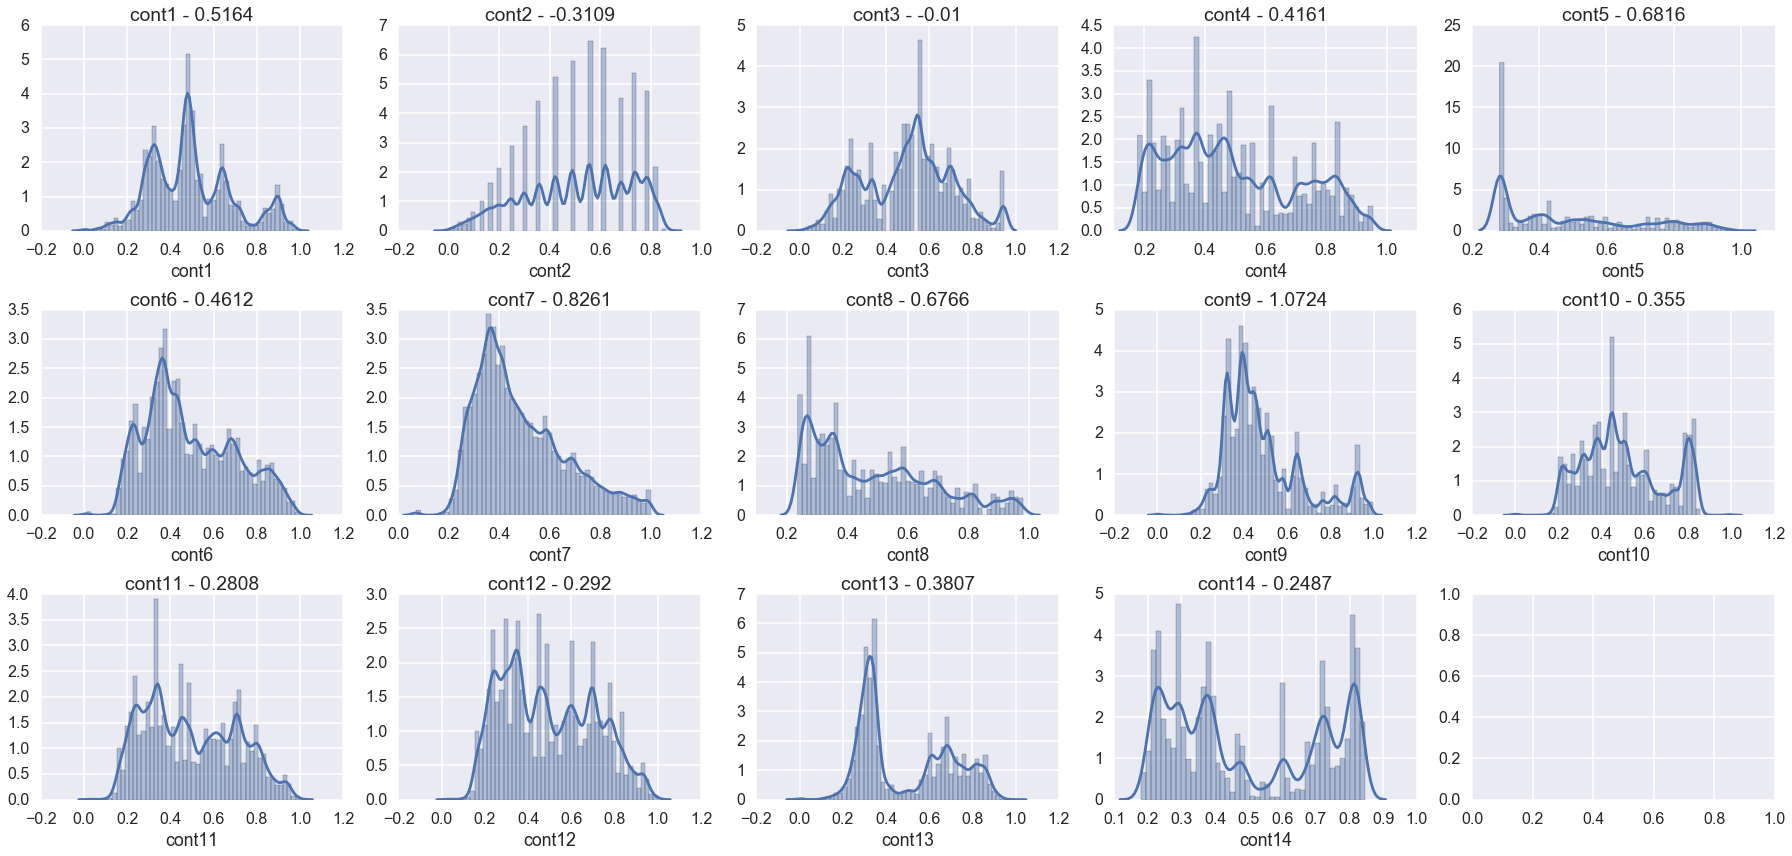

In [4]:
fig, axes = plt.subplots(3,5)
fig.set_size_inches(25, 12)
a = 1
for column in keepcont:
    sk= train[column].skew()
    
    plt.subplot(3,5,a)
    sns.distplot(train[column])
    plt.title(column+' - '+str(round(sk,4)))
    a+=1
    
plt.tight_layout()

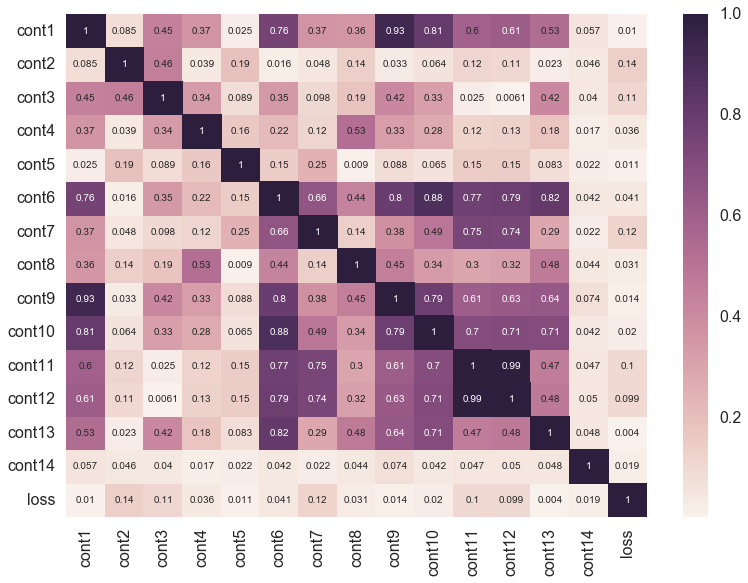

In [5]:
contFeatureslist = keepcont
contFeatureslist.append("loss")
correlationMatrix = train[contFeatureslist].corr().abs()

plt.subplots(figsize=(13, 9))
sns.heatmap(correlationMatrix,annot=True)

# Mask unimportant features
sns.heatmap(correlationMatrix, mask=correlationMatrix < 1, cbar=False)

plt.show()

In [18]:
keepcont = [col for col in train.columns if 'cont' in col]

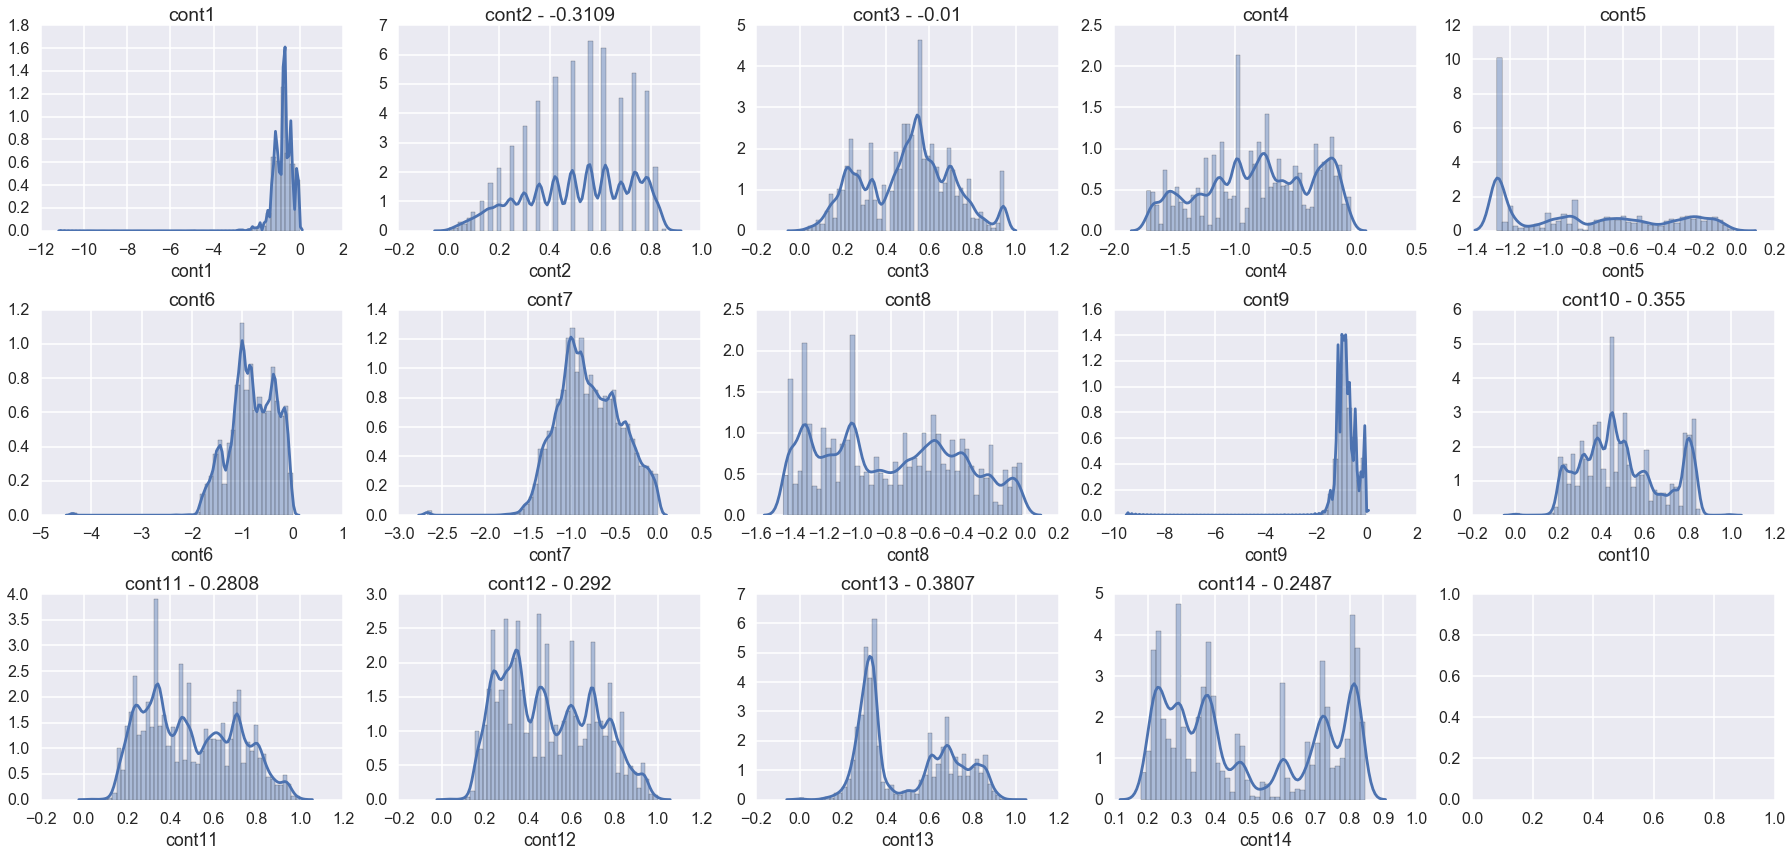

In [11]:
fig, axes = plt.subplots(3,5)
fig.set_size_inches(25, 12)
a = 1
for column in keepcont:
    sk = train[column].skew()
    
    plt.subplot(3,5,a)
    if (sk>0.40) | (sk<-0.40):
        dat = np.log(train[column])
        dat[dat==np.inf]=np.nan
        sns.distplot(dat)
        plt.title(column)
    else:
        sns.distplot(train[column])
        plt.title(column+' - '+str(round(sk,4)))
    a+=1
    
plt.tight_layout()

In [19]:
# Get rid of 1 or 9, 11 or 12, 6 or 10,
# transform 6, 7, and 9/1. 

newlist = keepcont
newlist.remove("cont1")
newlist.remove("cont11")
newlist.remove("cont6")
newlist.append("loss")

dataset = train[newlist]
dataset.head()

,cont2,cont3,cont4,cont5,cont7,cont8,cont9,cont10,cont12,cont13,cont14,loss
0,0.245921,0.187583,0.789639,0.310061,0.335060,0.30260,0.67135,0.83510,0.594646,0.822493,0.714843,2213.18
1,0.737068,0.592681,0.614134,0.885834,0.436585,0.60087,0.35127,0.43919,0.366307,0.611431,0.304496,1283.60
2,0.358319,0.484196,0.236924,0.397069,0.315545,0.27320,0.26076,0.32446,0.373424,0.195709,0.774425,3005.09
3,0.555782,0.527991,0.373816,0.422268,0.391128,0.31796,0.32128,0.44467,0.321570,0.605077,0.602642,939.85
4,0.159990,0.527991,0.473202,0.704268,0.247408,0.24564,0.22089,0.21230,0.202213,0.246011,0.432606,2763.85


/Users/elena/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/elena/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/elena/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

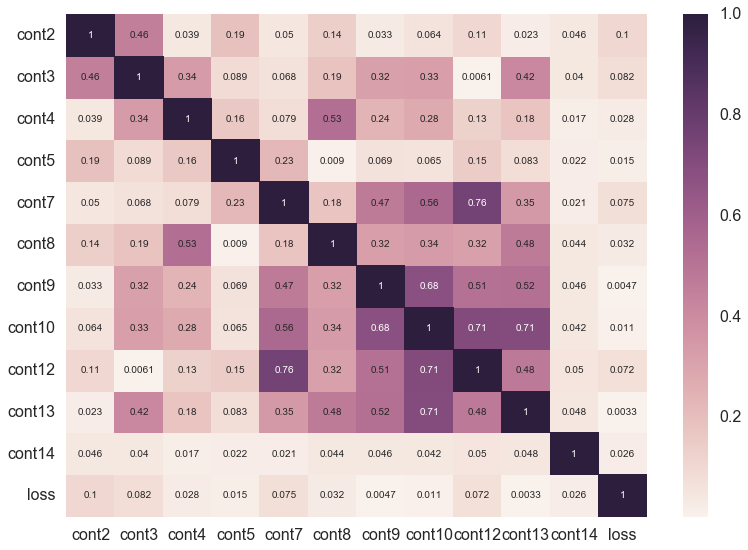

In [20]:
#dataset["cont10"]=np.log(dataset['cont10'])
vals_to_log = list(["cont7","cont9","loss"])
for col in vals_to_log:
    dataset.loc[:,col]=np.log(dataset.loc[:,col])
    
correlationMatrix2 = dataset.corr().abs()

plt.subplots(figsize=(13, 9))
sns.heatmap(correlationMatrix2,annot=True)

# Mask unimportant features
sns.heatmap(correlationMatrix2, mask=correlationMatrix2 < 1, cbar=False)
plt.show()

### Random Forest

In [25]:
model = RandomForestRegressor()
x = dataset[list(dataset.columns[:-1])]
print list(dataset.columns[:-1])
y = dataset['loss']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.75)

model.fit(X_train,y_train)
mae = mean_absolute_error(np.exp(y_test),np.exp(model.predict(X_test)))
print mae

['cont2', 'cont3', 'cont4', 'cont5', 'cont7', 'cont8', 'cont9', 'cont10', 'cont12', 'cont13', 'cont14']
1927.50665431
